In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import glob

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
#from tools.preprocess import preproc_maria,preproc_haiyan
sys.path.insert(1, '../')
import read_stuff as read
import ts_models
import properscoring as ps
from copy import deepcopy
#import benchmark
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
import random
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(8888)

In [3]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

16007

In [5]:
def prepare_tensors(filepath='./haiyan_store',splitnum=None,explag=23,notensor='No'):
    if './haiyan_store' in filepath:
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['test'][explag]
    elif filepath=='./maria_store':
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['test'][explag]
    
    X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
    X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
    X_totest, y_totest = read.delete_padding(Xtest,ytest)
    
    if notensor=='No':
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        #train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
        #val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
        #test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
        
        return {'train':[train_Xtensor,train_ytensor],'valid':[val_Xtensor,val_ytensor],'test':[test_Xtensor,test_ytensor]}
    elif notensor=='Yes':
        return {'train':[X_totrain, y_totrain],'valid':[X_tovalid, y_tovalid],'test':[X_totest, y_totest]}

storedata,store_notensor,store_low,store_axisym,store_upper,store_minus,store_addasym,store_minusasym,store_axisym_preserve = {},{},{},{},{},{},{},{},{}
for i in tqdm(range(0,40)):
    storedata[i] = prepare_tensors('./haiyan_store',i,23,'No')
    store_notensor[i] = prepare_tensors('./haiyan_store',i,23,'Yes')
    store_low[i] = prepare_tensors('./haiyan_store/sensitivity/lowlevel',i,23,'Yes')
    store_axisym[i] = prepare_tensors('./haiyan_store/sensitivity/axisym',i,23,'Yes')
    store_axisym_preserve[i] = prepare_tensors('./haiyan_store/sensitivity/axisym_preserve',i,23,'Yes')
    store_addasym[i] = prepare_tensors('./haiyan_store/sensitivity/asym',i,23,'Yes')
    store_minusasym[i] = prepare_tensors('./haiyan_store/sensitivity/minus_asym',i,23,'Yes')
    store_upper[i] = prepare_tensors('./haiyan_store/sensitivity/upperlevel',i,23,'Yes')
    store_minus[i] = prepare_tensors('./haiyan_store/sensitivity/minus_axisym',i,23,'Yes')

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
import benchmark
import importlib
importlib.reload(benchmark)

<module 'benchmark' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/benchmark.py'>

# Performance Metrics

## VAE

In [7]:
losscoeffs = [0.45,0.55,0.65,0.75,0.85,0.95,1]#[0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
numsplit = 40
trailnums = 30
np.random.seed(8888)
seeds = np.random.randint(0, 500,size=20)

seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Spread-skill

In [20]:
import importlib,plotting
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
importlib.reload(plotting)

<module 'plotting' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/plotting.py'>

In [9]:
snum=2
coeff=0.75
splitno = 19
modelno = 0

def get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snum,coeff=coeff,splitno=splitno,modelno=modelno,category='valid',meancat='meanvals'):
    aaaaaa = [np.percentile(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category],i) for i in np.arange(0,95,5)]
    
    hihihi = []
    hihihib = []

    ssRel = 0
    nPts = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category]).size
    for i in range(len(aaaaaa)-1):
        ytruth = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                         seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        nPtsbin = ytruth.size
        ypred = np.asarray(seeds_store[seeds[snum]][coeff][splitno][meancat][modelno])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                  seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        spreadss = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                             seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))] 
        try:
            hihihi.append(np.sqrt(mean_squared_error(ytruth,ypred)))
            ssRel += (nPtsbin/nPts) * np.abs(np.sqrt(mean_squared_error(ytruth,ypred)) - np.mean(spreadss))
        except:
            hihihi.append(np.nan)
            ssRel += 0
    return {'spreadlim':aaaaaa,'error':hihihi,'ssRel':ssRel}

In [22]:
allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(39):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='valid',meancat='meanvals') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [33]:
ssRels_array = np.zeros((39,9))
for i in (range(39)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.85][i][j]['ssRel'] for k in range(20)]).min()

<AxesSubplot:ylabel='Density'>

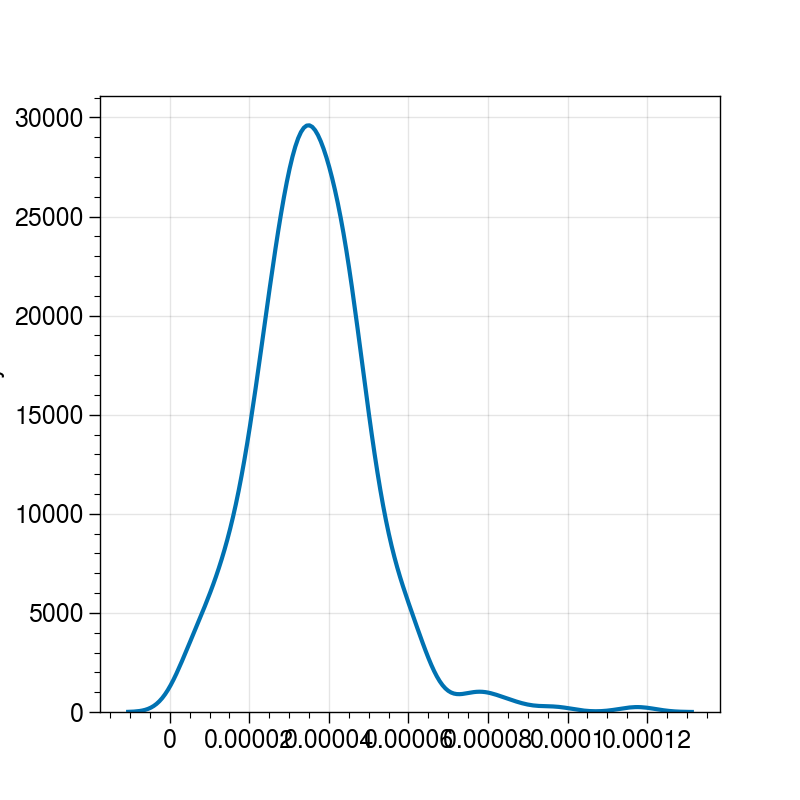

In [34]:
import seaborn as sns
sns.kdeplot(ssRels_array.flatten())

In [109]:
ssRels_array.flatten()[ssRels_array.flatten()>=np.percentile(ssRels_array.flatten(),97.5)]

array([8.29846111e-05, 7.70579313e-05, 7.73395611e-05, 6.54842248e-05,
       1.17498147e-04, 7.82984797e-05, 9.67301294e-05, 7.18329822e-05,
       8.68197764e-05])

In [35]:
((np.sort(ssRels_array.flatten())[:])-np.sort(ssRels_array.flatten())[0])/np.sort(ssRels_array.flatten())[0]*100

array([   0.        ,   30.34770466,   32.02776458,   49.27539473,
         78.28156576,   92.40506904,  101.63791206,  113.61777754,
        123.19241571,  136.2282542 ,  184.65424422,  230.43312036,
        230.77387464,  255.22985369,  266.31546128,  272.6686651 ,
        272.94975219,  275.34213045,  282.32226395,  296.34372544,
        306.80638527,  325.0071599 ,  343.01365454,  346.47894005,
        353.40360015,  381.58088018,  394.38953662,  394.40669557,
        396.14896207,  396.54347568,  399.542646  ,  400.05961464,
        433.42240276,  467.0434759 ,  469.35633084,  482.08709113,
        484.58937644,  491.24111024,  491.79016999,  497.00325171,
        497.58260362,  510.5956894 ,  518.44189815,  524.49961795,
        525.89493401,  531.24654644,  533.34943404,  533.56433404,
        536.77530224,  542.9486911 ,  563.29546985,  568.73888403,
        578.48006071,  579.00841296,  589.48505778,  592.45366032,
        599.89640538,  600.18231565,  606.04581648,  614.16424

In [36]:
np.dstack(np.unravel_index(np.argsort(ssRels_array.ravel()), ssRels_array.shape))

array([[[26,  8],
        [26,  4],
        [26,  2],
        [26,  0],
        [30,  0],
        [19,  5],
        [26,  3],
        [26,  5],
        [29,  5],
        [26,  7],
        [31,  0],
        [25,  1],
        [25,  5],
        [25,  6],
        [26,  1],
        [26,  6],
        [25,  0],
        [25,  4],
        [25,  3],
        [31,  4],
        [31,  5],
        [30,  1],
        [30,  7],
        [25,  7],
        [30,  3],
        [25,  8],
        [30,  2],
        [25,  2],
        [17,  2],
        [30,  6],
        [15,  0],
        [15,  4],
        [31,  1],
        [29,  8],
        [22,  4],
        [29,  4],
        [31,  6],
        [ 5,  4],
        [18,  8],
        [17,  5],
        [15,  1],
        [17,  8],
        [30,  4],
        [17,  7],
        [18,  4],
        [31,  7],
        [14,  2],
        [17,  4],
        [35,  5],
        [22,  8],
        [14,  8],
        [35,  1],
        [18,  6],
        [15,  3],
        [17,  6],
        [ 

In [74]:
splitnum=[26,26,26,26,30,19,26,26,29,26]
mdlnum = [8,4,2,0,0,5,3,5,5,7]

storeLW,storeSW,storeLW_logvar = [],[],[]
storeTS = []
for splitz,mdlnum in zip(splitnum,mdlnum):
    sdnum = np.asarray([allsave[k][0.85][splitz][mdlnum]['ssRel'] for k in range(20)]).argmin()
    bestmodel = seeds_store[seeds[sdnum]][0.85][splitz]['models'][mdlnum]
    pcalw,pcasw = read_and_proc.depickle('./haiyan_store/pca/lw/'+str(splitz)+'/PCA3D.pkg'),read_and_proc.depickle('./haiyan_store/pca/sw/'+str(splitz)+'/PCA3D.pkg')
    fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW')
    flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW')
    fl_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW_logvar')
    fl_swlogvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW_logvar')
    flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    flas_lwlogvar = np.squeeze(np.dot(fl_logvar,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_swlogvar = np.squeeze(np.dot(fl_swlogvar,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    TS_lw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl)
    TS_lwlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl_logvar)
    TS_sw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],flsw)
    TS_swlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],fl_swlogvar)
    storeLW.append(flas)
    storeSW.append(flas_sw)
    storeLW_logvar.append(flas_lwlogvar)
    storeTS.append({'lw':TS_lw,'sw':TS_sw,'lw_logvar':TS_lwlogvar,'sw_logvar':TS_swlogvar})

(0.0, 2.0)

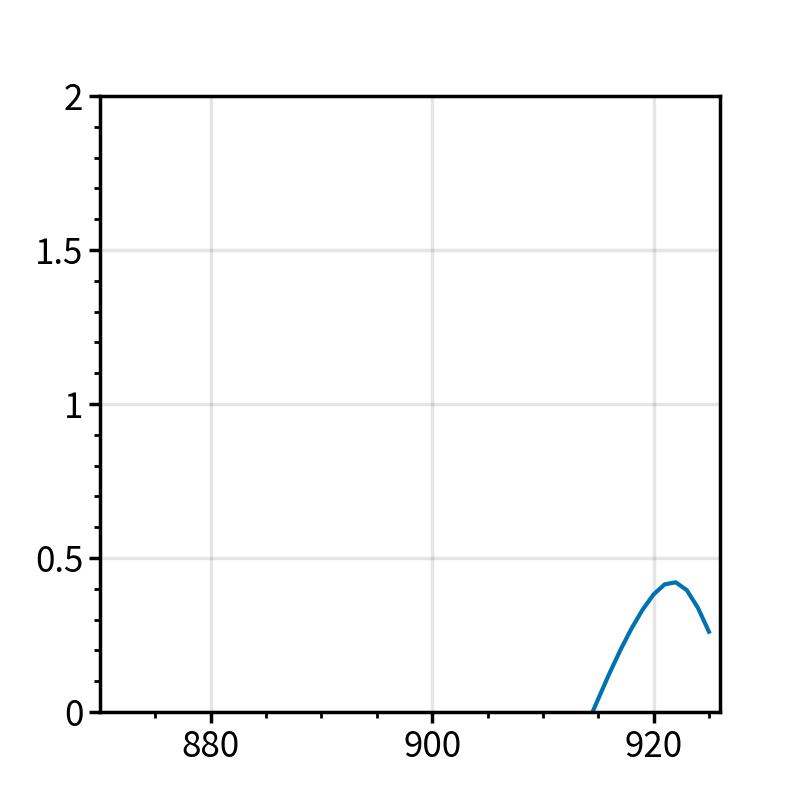

In [106]:
plt.plot(storeTS[0]['lw_logvar'])
#plt.plot(storeTS[0]['lw'])
plt.xlim(870,926)
plt.ylim(0,2)
#79, 132, 195, 282, 353, 413, 496, 559, 567, 610, 658, 721, 797,
#        810, 870, 926

(610.0, 655.0)

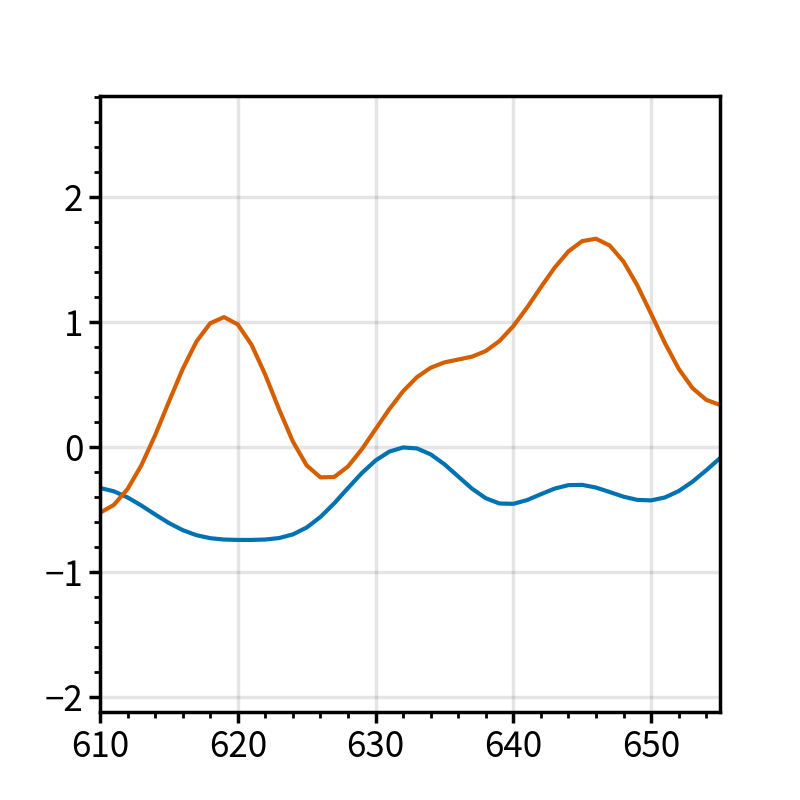

In [82]:
plt.plot(storeTS[0]['lw_logvar'])
plt.plot(storeTS[0]['lw'])
plt.xlim(610,655)

In [77]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [1000,100]
preslv = np.linspace(1000,100,10)
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

for modelrank in tqdm(range(0,9)):
    fig,axs = plot.subplots(ncols=4,nrows=1,axwidth=3.495,refaspect=0.9931)
    for i,obj in enumerate(pressure_indx):
        if i==0:
            levels= np.linspace(-0.0026,0.0026,14)
            ticks = [-0.001,0,0.001]
        else:
            levels= np.linspace(-0.0046,0.0046,24)
            ticks = [-0.003,0,0.003]
        apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(storeLW[modelrank])[obj,...],ANGLE,True,False))))
        values = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(storeLW[modelrank])[obj,...],ANGLE,True,False))))[0,0]
        maps = axs[i].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd',levels=levels)
        axs[i].format(ltitle='$\mu_{LW}$ (Haiyan)',xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km',rtitle=f'{pressurelevel[i]} hPa; Rank:{modelrank+1}',xlim=[-600,600])
        axs[i].colorbar(maps,loc='ll',ticks=ticks)
    
    for i,obj in enumerate(pressure_indx):
        apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(storeLW_logvar[modelrank])[obj,...],ANGLE,True,False))))
        values = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(storeLW_logvar[modelrank])[obj,...],ANGLE,True,False))))[0,0]
        if i==0:
            levels= np.linspace(-0.0016,0.0016,14)
            ticks = [-0.001,0,0.001]
        else:
            levels= np.linspace(-0.0066,0.0046,24)
            ticks = [-0.003,0,0.003]
        maps = axs[i+2].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(apl==values,apl),cmap='cividis',levels=levels)
        axs[i+2].format(ltitle='$log\sigma^2_{LW}$ (Haiyan)',xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km',rtitle=f'{pressurelevel[i]} hPa; Rank:{modelrank+1}',xlim=[-600,600])
        axs[i+2].colorbar(maps,loc='ll',ticks=ticks)
        
    axs.format(abc=True,abcloc='ur')
    plt.savefig('./figures/SI/structures/optimstructures3D_haiyan_best_'+str(modelrank)+'.png',dpi=600)
    plt.close()

  0%|          | 0/9 [00:00<?, ?it/s]

In [110]:
pressure_indx

[0, 9]

In [113]:
AAAu = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.std(np.asarray([np.asarray(storeLW[modelranki])[9,...] for modelranki in range(len(storeLW))]),axis=0),ANGLE,True,False))))

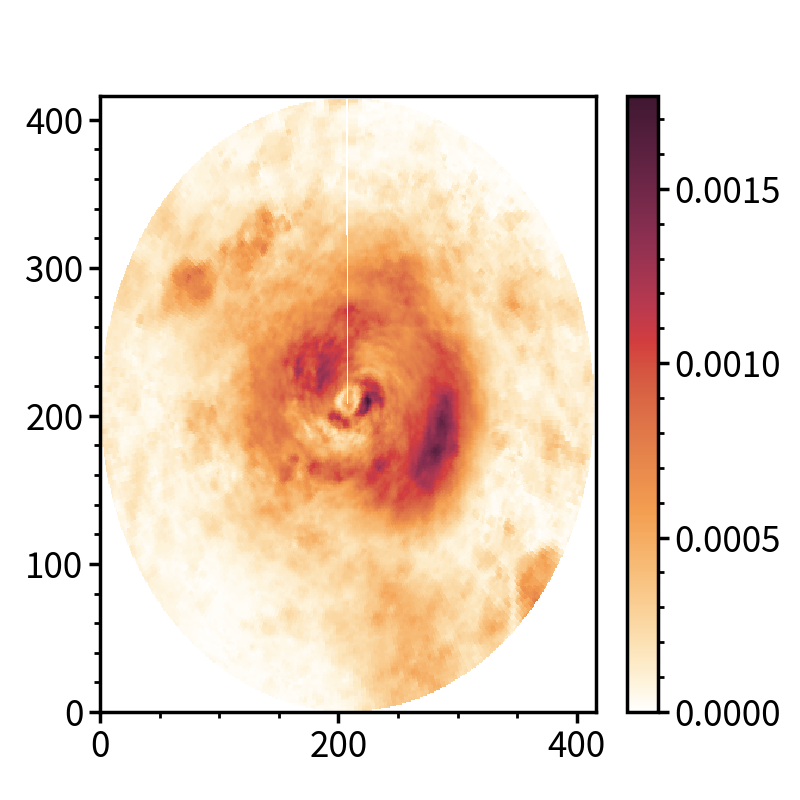

In [115]:
plt.pcolormesh(AAAu)
plt.colorbar()
plt.show()